In [1]:
import pandas as pd
from functions.displayer import (plot_cycle,
                                 plot_windowed_cycle)
from functions.data_processor import DataProcessor
from models.encoder import Encoder
from models.decoder import Decoder
from models.autoencoder import Autoencoder
import matplotlib.pyplot as plt

In [2]:
# PATHs
TRAIN_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'

<h1><center>Unsupervised anomaly detection using autoencoders</center></h1>
<h3><center>Multivariate time series - Wafers</center></h3>

-------

## I. Data preparation

#### 1. Data reading

- Read csv files

In [3]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

- Extract X and y

In [4]:
# Training set
x_train = train[['id', 'value']]
y_train = train.groupby(['id']).apply(lambda X: X.isAnomaly.iloc[0])
# Testing set
x_test = test[['id', 'value']]
y_test = test.groupby(['id']).apply(lambda X: X.isAnomaly.iloc[0])

#### 2. Data description

Data contains a calculated measure based on multiple sensors. This measure is **cyclic** with **152 timestamp per cycle**.

In [5]:
n_train_anomaly = y_train.value_counts()
n_test_anomaly = y_test.value_counts()

In [6]:
print('Train anomaly distribution: ', n_train_anomaly, sep='\n', end='\n\n')
print('Test anomaly distribution: ', n_test_anomaly, sep='\n')

Train anomaly distribution: 
 1    903
-1     97
dtype: int64

Test anomaly distribution: 
 1    5499
-1     665
dtype: int64


#### 3. Data visualization

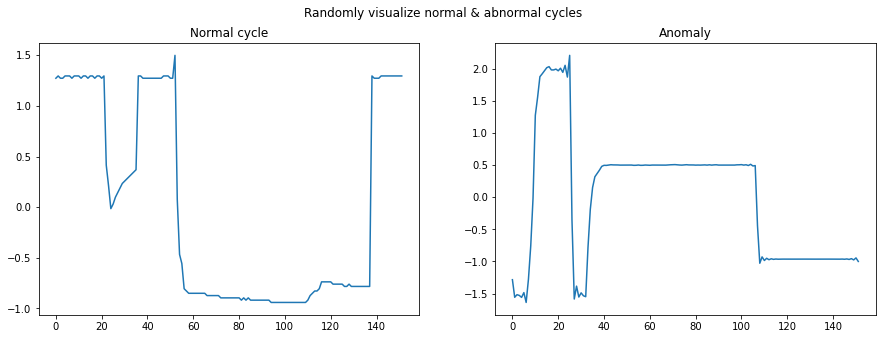

In [7]:
plot_cycle(train)

#### 4. Training set

- The training set for timeseries anomaly detection should be composed exclusively of normal cycles. Since the model's objective is to learn features intrinsic of normal cycles and learn to reconstruct the original series from a small latent space. The error would be higher if the cycle prove to be an anomaly.

In [8]:
x_train = x_train[train.isAnomaly==1].reset_index(drop=True)

#### 5. Data processing 

- Data proccessor parameters

In [9]:
col_names = ['value']
id = 'id'

- Create data processor

In [10]:
dp = DataProcessor(x_train, x_test, col_names, id)

- Scaling data

In [11]:
dp.scale_data()

- Reshaping data

In [12]:
dp.reshape_data()
print(dp.s_train.shape)

(903, 152, 1)


- Windowing: *Size = 10, gap = 4*

In [13]:
dp.windowing(10, 4)

In [14]:
print('Train shape after windowing: ', dp.w_train.shape)

Train shape after windowing:  (32508, 10, 1)


- Visualize windowing overlapping impact

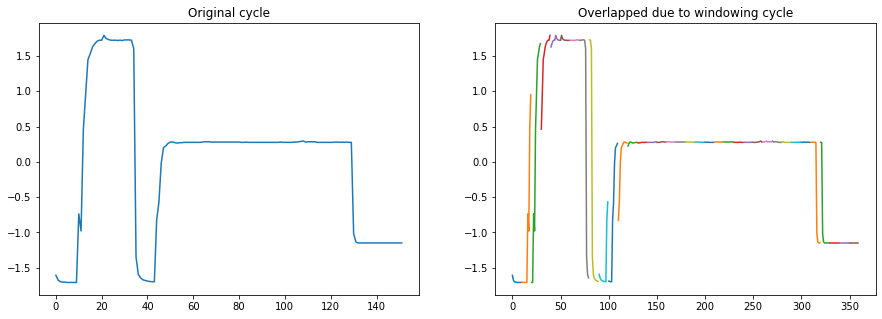

In [15]:
plot_windowed_cycle(dp.s_train, dp.w_train, gap=4)

## II. Training an auto-encoder

#### 0. Dimensions definition

In [16]:
# Training set shape
shape = dp.w_train.shape
# Sub sequence shape
length_sequence = shape[1]
n_features = shape[2]
# Latent dimension 
n_latent = 2

#### 1. Create an LSTM encoder

In [17]:
encoder = Encoder(length_sequence, n_features, n_latent).model

#### 2. Create an LSTM decoder

In [18]:
decoder = Decoder(length_sequence, n_features, n_latent).model

#### 3. Create an auto-encoder

In [19]:
ae = Autoencoder(encoder, decoder).model

#### 4. Compile and explore the auto-encoder

In [20]:
ae.compile(optimizer='adam', loss='mse')
ae.summary()

Model: "Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 Encoder-Model (Functional)  (None, 2)                 4418      
                                                                 
 Decoder-Model (Functional)  (None, 10, 1)             4513      
                                                                 
Total params: 8,931
Trainable params: 8,931
Non-trainable params: 0
_________________________________________________________________


#### 5. Fitting the model

In [21]:
ae.fit(x=dp.w_train,
       y=dp.w_train,
       batch_size=32,
       epochs=10,
       validation_data=(dp.w_test, dp.w_test))

Epoch 1/10
1016/1016 [==============================] - 28s 25ms/step - loss: 0.1688 - val_loss: 0.0955
Epoch 2/10
1016/1016 [==============================] - 24s 24ms/step - loss: 0.0894 - val_loss: 0.0794
Epoch 3/10
1016/1016 [==============================] - 23s 23ms/step - loss: 0.0743 - val_loss: 0.0649
Epoch 4/10
1016/1016 [==============================] - 23s 23ms/step - loss: 0.0643 - val_loss: 0.0570
Epoch 5/10
1016/1016 [==============================] - 23s 23ms/step - loss: 0.0569 - val_loss: 0.0536
Epoch 6/10
1016/1016 [==============================] - 23s 23ms/step - loss: 0.0502 - val_loss: 0.0499
Epoch 7/10
1016/1016 [==============================] - 24s 24ms/step - loss: 0.0472 - val_loss: 0.0398
Epoch 8/10
1016/1016 [==============================] - 24s 24ms/step - loss: 0.0417 - val_loss: 0.0482
Epoch 9/10
1016/1016 [==============================] - 29s 29ms/step - loss: 0.0372 - val_loss: 0.0541
Epoch 10/10
1016/1016 [==============================] - 30s 29m

#### 6. Test  windowed prediction

In [22]:
w_pred = ae.predict(dp.w_test)

6935/6935 [==============================] - 25s 3ms/step


#### 7. Visualize a windowed prediction

In [26]:
cycle = 5

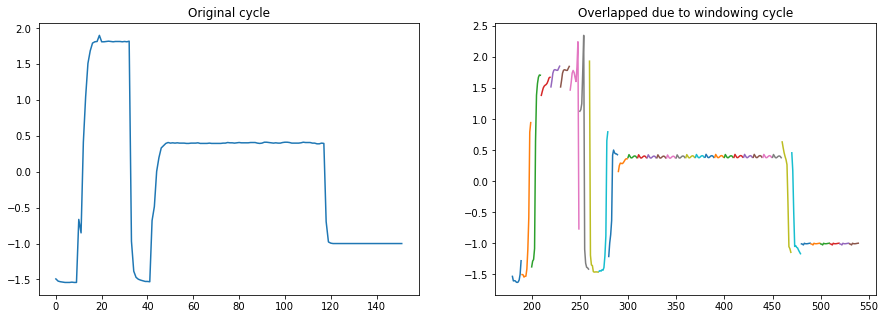

In [27]:
plot_windowed_cycle(dp.s_test, w_pred, cycle=cycle, gap=4)

## III. Reconstruction

#### 1. Transform windowed prediction into reconstructed cycles 

#### 2. Average reconstruction error per cycle